In [1]:
import numpy as np
import pandas as pd

In [2]:
cd ../../

/home/michael/Dropbox/PhD/Python/unified_model


In [3]:
# Mechanical system imports
from unified_model.mechanical_system.damper.damper import Damper
from unified_model.mechanical_system.input_excitation.accelerometer import AccelerometerInput
from unified_model.mechanical_system.spring.magnetic_spring import MagneticSpring
from unified_model.mechanical_system.magnet_assembly.magnet_assembly import MagnetAssembly

from unified_model.electrical_system.flux.utils import FluxDatabase
from unified_model.electrical_system.flux.model import flux_interpolate
from unified_model.electrical_system.electrical_system import OpenCircuitSystem


import matplotlib.pyplot as plt

In [4]:
spring = MagneticSpring(fea_data_file = 'unified_model/mechanical_system/spring/data/10x10alt.csv', model='savgol_smoothing', model_type='interp')

In [5]:
magnet_assembly = MagnetAssembly(n_magnet=1,
                                h_magnet=10,
                                h_spacer=0,
                                dia_magnet=10,
                                dia_spacer=10)

In [6]:
damper = Damper(model='constant', model_kwargs={'damping_coefficient' : 0.030})

In [7]:
accelerometer = AccelerometerInput('unified_model/mechanical_system/input_excitation/data/2018-10-04/log_02.csv',
                                  accel_column='z_G',
                                  time_column='time(ms)',
                                  time_unit='ms')

In [8]:
from unified_model.model import unified_ode_coupled_oc

In [9]:
# flux database
fdb = FluxDatabase('../Research/fea-flux-curves-numr[1-20-600]-numz[1-20-600]-wdiam[0.127]-2018-03-24[10.45.22].csv', fixed_velocity=0.35)

In [458]:
phi = fdb.query(winding_num_z='21', winding_num_r='401')
z = fdb.z
ocs = OpenCircuitSystem(z_index=z, phi_arr=phi, flux_model='flux_interpolate', coil_center=0.06, mf=magnet_assembly.get_height())

In [467]:
kwargs = {'spring' : spring,
         'damper': damper,
         'input' : accelerometer,
         'magnet_assembly': magnet_assembly,
         'flux_model': ocs.flux_model,
         'coupling': 0.01}

In [468]:
from scipy.integrate import solve_ivp

In [469]:
from unified_model.electrical_system.electrical_system import _gradient

def unified_ode_coupled_oc(t, y, kwargs):
    """
    A coupled unified electro-mechanical model.
    """

    spring = kwargs['spring']
    damper = kwargs['damper']
    mechanical_input = kwargs['input']
    magnet_assembly = kwargs['magnet_assembly']
    flux_model = kwargs['flux_model']
    coupling = kwargs['coupling']

    x1, x2, x3, x4, x5 = y  # tube displacement, tube velocity, magnet displacement, magnet velocity, flux, emf

    if x1 <= 0 and x2 <= 0:
        x1 = 0
        x2 = 0

    x1_dot = x2
    x2_dot = mechanical_input.get_acceleration(t)
    x3_dot = x4

    
    dphi_dz = _gradient(flux_model, x=(x3-x1))
    x5_dot = dphi_dz * (x4-x2)  # emf
    
    coupling_force = coupling*np.abs(dphi_dz)*(x4-x2)
    
    x4_dot = (spring.get_force(x3 - x1) - magnet_assembly.get_weight() -damper.get_force(
        x4 - x2) - coupling_force) / magnet_assembly.get_mass()

    return [x1_dot, x2_dot, x3_dot, x4_dot, x5_dot]


In [470]:
psoln = solve_ivp(fun=lambda t, y: unified_ode_coupled_oc(t, y, kwargs),
                  t_span=(3,8),
                 y0=[0,0,0.04,0, 0],
                 max_step=0.001)

In [471]:
x1 = psoln.y[0, :]  # Tube displacement
x2 = psoln.y[1, :]  # Tube velocity
x3 = psoln.y[2, :]  # Magnet assembly displacement
x4 = psoln.y[3, :]  # Magnet assembly velocity
x5 = psoln.y[4, :]  # Flux


x_relative_displacement = x3 - x1
x_relative_velocity = x4 - x2

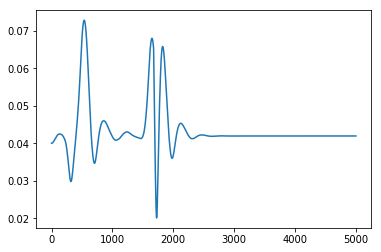

In [472]:
import matplotlib.pyplot as plt
plt.plot(x3-x1)  # displacement

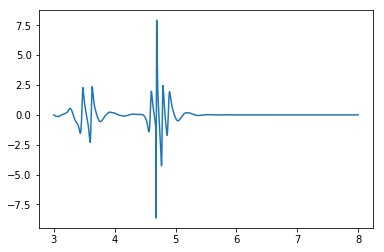

In [473]:
plt.plot(psoln.t, np.gradient(x5)/np.gradient(psoln.t))
#plt.xlim(0.,0.2)

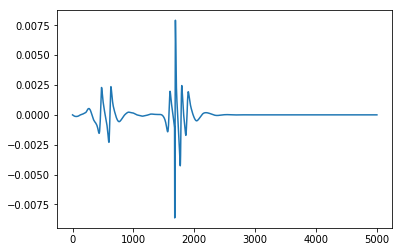

In [474]:
plt.plot(np.gradient(x5))